In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS
import string

## Učitavanje skupa podataka

In [4]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

Skup za obučavanje sadrži 159571 instanci, a skup za testiranje 153164

In [5]:
data_train.shape

(159571, 8)

In [6]:
data_test.shape

(153164, 2)

## Analiza skupa podataka

Komentari u tekstualnom formatu se nalaze u koloni comment_text, ostale kolone označavaju klase kojima komentar pripada, označene jedinicom za svaku klasu kojoj pripada, nulom u suprotnom.

In [7]:
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
data_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Tipovi svake od kolona:

In [9]:
data_train.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

Primer jedne instance, tj. komentara i njemu pridruženih klasa
- ovaj komentar označen je sa dve labele: toxic i insult

In [10]:
print(data_train['comment_text'][159546])
print('\n')
print(data_train.iloc[159546].drop(['id', 'comment_text']))

"

Hey listen don't you ever!!!! Delete my edits ever again I'm annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes what I write. just stop!!!! Please STOP!!!! You don't work 2k or WWE games so stop deleting other peoples shit if I get it wrong or others get it wrong let them they will get the hang of it eventually but don't stick your most ass in their and I'm gonna delete the ""please do not insert the roster"" shit how do you not have it if has been confirmed!!!!! God your stupid."


toxic            1
severe_toxic     0
obscene          0
threat           0
insult           1
identity_hate    0
Name: 159546, dtype: object


Provera da li postoje neke nedostajuće vrednosti

In [11]:
data_train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Izdvajanje 6 klasa u promenljivu labels

In [12]:
labels = data_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [13]:
labels.shape

(159571, 6)

### Vizualizacija podataka

Prikaz brojnosti komentara po klasama

In [14]:
frequency_per_class = labels.sum()
frequency_per_class

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

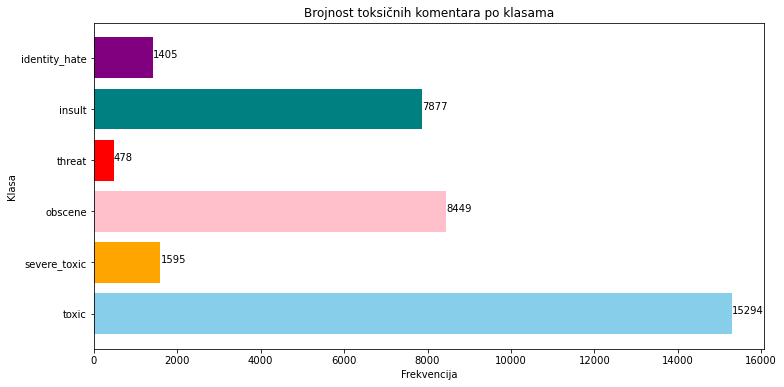

In [15]:
colors = ['skyblue', 'orange', 'pink', 'red', 'teal', 'purple', 'khaki']
plt.figure(figsize=(12, 6))
plt.title('Brojnost toksičnih komentara po klasama')
plt.xlabel('Frekvencija')
plt.ylabel('Klasa')

plt.barh(frequency_per_class.index, frequency_per_class.values, color=colors)
for index, value in enumerate(frequency_per_class):
    plt.text(value, index, str(value))
    
plt.savefig('plots and images/01_frequency_bar.png', orientation='landscape')
plt.show()

S obzirom na to da se radi o višelabelarnoj klasifikaciji, jedna instanca može pripadati istovremeno dvema ili više klasa. Komentar može npr. biti označen kao toksičan i uvreda, ali ne i pretnja, amože i spadati pod svih 6 obeležja i tako imati labelu koja za svih 6 klasa ima vrednost 1.

Zbog toga je dat i grafički prikaz broja komentara po tome da li su svrstani u jednu, dve, tri, četiri, pet, ili svih šest klasa.

In [16]:
counts = data_train.iloc[:, 2:].sum(axis=1).value_counts()
multilabels = counts[1:]
multilabels

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64

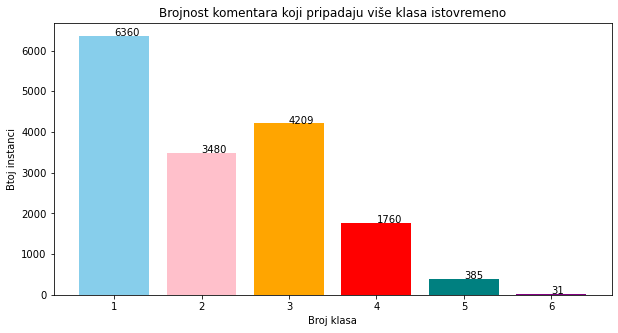

In [17]:
plt.figure(figsize=(10, 5))
plt.title('Brojnost komentara koji pripadaju više klasa istovremeno')
plt.xlabel('Broj klasa')
plt.ylabel('Btoj instanci')

plt.bar(multilabels.index, multilabels.values, color=colors)
for index, value in enumerate(multilabels.sort_index()):
    plt.text(index+1, value, str(value))

plt.savefig('plots and images/02_multilabels.png', orientation='landscape')

plt.show()

Dakle, najviše komentara pripada samo jednoj klasi, a samo 31 komentar ispunjava uslove za svaku od 6 klasa (istovremeno je toxic, severe_toxic, insult, obscene, threat i identity hate)

U nastavku će biti prikazano koliko instanci nije klasifikovano u nijednu od ovih 6 klasa. Te instance zapravo predstavljaju "čiste", tj. netoksične komentare. Grafički prikaz biće dat u obliku pitice, kako bi se jasno video udeo toksičnih i netoksičnih komentara u celom skupu podataka.

In [18]:
untoxic = counts[0]
untoxic

143346

In [19]:
print('Udeo neoznacenih komentara:  {:.2%}'.format(untoxic/data_train.shape[0]))

Udeo neoznacenih komentara:  89.83%


Dakle, samo oko 10% trening skupa su toksični komentari.

Dodatno, ako posmatramo samo ovih 10% toksičnih komentara, i unutar njih važi neravnomerna raspodela po klasama (već je bilo prikazano gore u obliku stubića)

In [20]:
toxic = data_train.shape[0] - untoxic

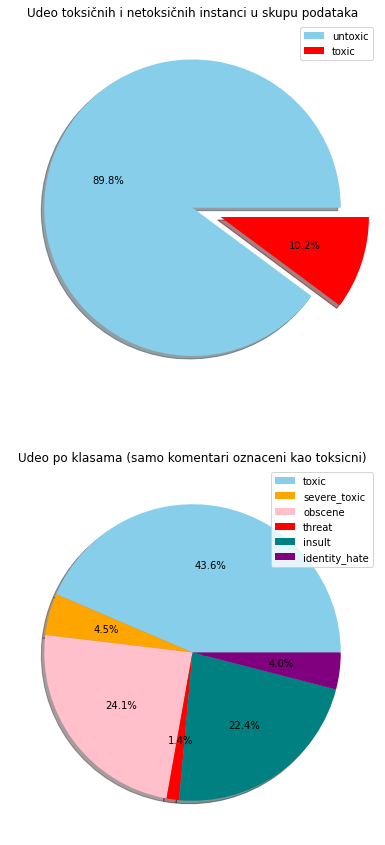

In [49]:
plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
plt.title('Udeo toksičnih i netoksičnih instanci u skupu podataka')
plt.pie([untoxic, toxic] , colors=['skyblue', 'red'], explode=[0, 0.2], autopct='%1.1f%%', shadow=True)
plt.legend(['untoxic', 'toxic'], loc='best')

plt.subplot(2, 1, 2)
plt.title('Udeo po klasama (samo komentari oznaceni kao toksicni)')
plt.pie(frequency_per_class, colors=colors, autopct='%1.1f%%', shadow=True)
plt.legend(loc='best', labels=frequency_per_class.index)

plt.savefig('plots and images/03_pie_class_distribution.png')
plt.show()

Odavde je jasno da je skup podataka izuzetno neizbalansiran.

## Analiza teksta

U ovom delu, biće prikazane reči koje su najfrekventnije u instancama određenih klasa. U vidu oblaka reči, vizualizovane su reči koje se ponavljaju u toksičnim komentarima. Što je reč krupnija na slici, to se ona češće pojavljuje u skupu. Na osnovu ovoga, možemo da znamo kakve reči možemo očekivati u svakoj od klasa.

Funkcija koja formira wordcloud za konkretnu klasu:

In [23]:
def get_wordcloud(data, label, show=False):
    
    d = data[data[label]==1]
    words = ' '.join([text for text in d['comment_text'] ])

    wordcloud = WordCloud(width=2500,
                      height=1600,
                      max_words=500,
                      collocations=False,
                      stopwords=STOPWORDS).generate(words)

    if show:
        plt.title(str(label) + ' wordcloud')
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.savefig('plots and images/wordclouds/' + str(label) + '.png')
        plt.show()
        
    return wordcloud

In [24]:
#wordcloud_toxic = get_wordcloud(data_train, 'toxic', True)
#wordcloud_insult = get_wordcloud(data_train, 'insult', True)
#wordcloud_severe_toxic = get_wordcloud(data_train, 'severe_toxic', True)
#wordcloud_threat = get_wordcloud(data_train, 'threat', True)
#wordcloud_identity_hate = get_wordcloud(data_train, 'identity_hate', True)
#wordcloud_obscene = get_wordcloud(data_train, 'obscene', True)

Slike oblaka reči za svaku od labela sačuvane su u direktorijumu plots and images/wordclouds. Ovde je prikazana jedna od njih, konkretno za labelu 'threat'.

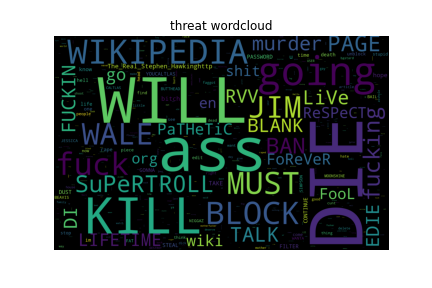

In [25]:
Image('plots and images/wordclouds/threat.png')

Dalje, možemo dodati atribut koji predstavlja broj reči po instanci, kako bismo imali uvid u to koliko su komentari dugački.

In [26]:
data_train['word_count'] = data_train['comment_text'].apply(lambda x : len(x.split()))
data_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,43
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,17
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,113
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13


Prikaz statistika za broj reči:

In [27]:
data_train['word_count'].describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: word_count, dtype: float64

In [28]:
# Broj komentara koji imaju samo jednu rec

data_train[data_train['word_count'] == 1].shape[0]

17

In [29]:
# Primer komentara od jedne reci

one_word_comments = data_train[data_train['word_count']==1]
one_word_comments['comment_text']

19815                                (www.ebenefits.va.gov)
52442                                                14:53,
52475                     User_talk:Blackson#Religious_bias
53787                         92.24.199.233|92.24.199.233]]
55751                                   Complaints/Mistakes
64904     http://en.wikipedia.org/wiki/Wikipedia_talk:No...
76037     http://finance.yahoo.com/news/7-fascinating-nu...
93586                                          {{unblock|yo
105657    Talk:E%3DMC%C2%B2_(Mariah_Carey_album)#Concern...
106891         http://en.wikipedia.org/wiki/Wikipedia:ELYES
109985                                             {{unbloc
110293    Wikipedia:Administrators%27_noticeboard/Incide...
111438                                   |needs-infobox=yes
117663                                    (talk)/(contribs)
127744                                      User:Wipeouting
130194                        hyper_individualist@yahoo.com
141293    http://www.haaretz.com/news/di

Odavde se vidi da njih ima jako malo, i da nemaju mnogo smisla (uglavnom su neki linkovi). Takvi komentari nisu od značaja za predviđanje, tako da možemo izbaciti ovih 17 redova:

In [30]:
data_train = data_train.drop(one_word_comments.index)
data_train.shape

(159554, 9)

In [31]:
# Komentar koji ima najvecu duzinu 

data_train[data_train['word_count']==1411]['comment_text']

140904    I AM AN LOSER ==== I AM AN LOSER == == I AM AN...
Name: comment_text, dtype: object

Histogram za broj reci

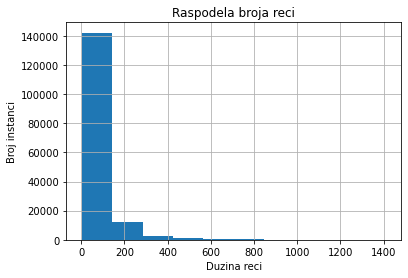

In [32]:
plt.title('Raspodela broja reci')
data_train['word_count'].hist()
plt.xlabel('Duzina reci')
plt.ylabel('Broj instanci')

plt.savefig('plots and images/04_hist_word_count.png')
plt.show()

Većina komentara ima do 100 reči. Podelićemo prethodni histogram na dva: prvi predstavlja raspodelu instanci koje imaju do 300 reči, a drugi raspodelu onih dužih komentara (više od 300 reči), koji su u manjini 

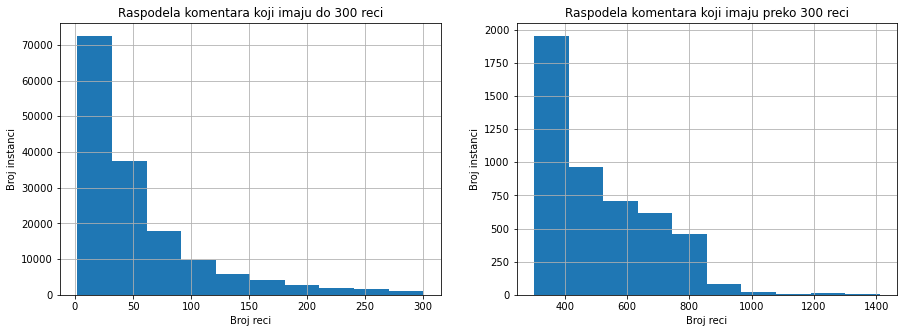

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Raspodela komentara koji imaju do 300 reci')
data_train[data_train['word_count'] <= 300]['word_count'].hist()
plt.xlabel('Broj reci')
plt.ylabel('Broj instanci')

plt.subplot(1, 2, 2)
plt.title('Raspodela komentara koji imaju preko 300 reci')
data_train[data_train['word_count'] > 300]['word_count'].hist()
plt.xlabel('Broj reci')
plt.ylabel('Broj instanci')

plt.savefig("plots and images/05_hist_wordcount_split.png")
plt.show()

Prosecan broj reci po instaci: 

In [34]:
data_train['word_count'].mean()

67.28058839013751

#### Prosečna dužina komentara je oko 67 reči.

## Čišćenje teksta

Sledeća funkcija priprema tekstove tako što uklanja sve nepotrebne reči, znakove interpukcije i slično

In [35]:
def prepare_text(text):
    clean_comment = re.sub('<.+?>', '', text)
    
    clean_comment = re.sub('\s+', '', clean_comment)
    # izbacuje znake interpunkcije
    clean_comment = re.sub('[%s]' % re.escape(string.punctuation), '', clean_comment)
    
    # izbacuje cifre i reci koje sadrze cifre
    clean_comment = re.sub('\w*\d\w*','', clean_comment)
    # izbacuje dodatne space-ove
    clean_comment = re.sub(' +',' ', clean_comment)
    
    return clean_comment.lower()